### lesson3

In [1]:
#オリジナルデータは以下
#http://timeseriesclassification.com/description.php?Dataset=ECG5000

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

def load_dataset():
    # 学習データ
    x_train = np.load('/root/userspace/public/lesson3/data/x_train.npy')
    y_train = np.load('/root/userspace/public/lesson3/data/y_train.npy')
    y_train = to_categorical(y_train[:, np.newaxis], num_classes = 5)
    
    # テストデータ
    x_test = np.load('/root/userspace/public/lesson3/data/x_test.npy')

    return (x_train, x_test, y_train)

x_train, x_test, y_train = load_dataset()

Using TensorFlow backend.


In [3]:
import tensorflow.python.keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D,BatchNormalization,Convolution2D
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, Activation, SimpleRNN, LSTM, Permute, GlobalAveragePooling1D, concatenate
from keras import Model

#参考モデル
#https://github.com/titu1994/LSTM-FCN/blob/master/ecg5000_model.py

ip = Input(shape=(x_train.shape[1:]))

#LSTM
x = LSTM(64, return_sequences=True)(ip)
x = LSTM(64, return_sequences=True)(x)
x = LSTM(64)(x)
x = Dropout(0.8)(x)

#CNN
y = Permute((2, 1))(ip)
y = Conv1D(64, 8, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = Conv1D(128, 5, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = Conv1D(64, 3, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = GlobalAveragePooling1D()(y)

#合わせる
x = concatenate([x, y])
out = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(ip, out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["acc"])

#logger = CSVLogger('history.log')
#reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1,monitor=metric,mode='max')
#model_checkpoint = ModelCheckpoint("best.model", monitor=metric, save_best_only=True, verbose=1,mode='max')
earlystopper = EarlyStopping(monitor="val_acc",patience=5, verbose=1,mode='max')
result=model.fit(x_train, y_train, epochs=100, batch_size=128, verbose=1, validation_split=0.2,
                 callbacks=[earlystopper])

Train on 3200 samples, validate on 800 samples
Epoch 1/100
3200/3200 [==============================] - 25s 8ms/step - loss: 0.7075 - acc: 0.7778 - val_loss: 0.5209 - val_acc: 0.8525
Epoch 2/100
3200/3200 [==============================] - 23s 7ms/step - loss: 0.2294 - acc: 0.9409 - val_loss: 0.3599 - val_acc: 0.9100
Epoch 3/100
3200/3200 [==============================] - 23s 7ms/step - loss: 0.1955 - acc: 0.9472 - val_loss: 0.3216 - val_acc: 0.9150
Epoch 4/100
3200/3200 [==============================] - 23s 7ms/step - loss: 0.1654 - acc: 0.9541 - val_loss: 0.3056 - val_acc: 0.9150
Epoch 5/100
3200/3200 [==============================] - 23s 7ms/step - loss: 0.1579 - acc: 0.9547 - val_loss: 0.2647 - val_acc: 0.9275
Epoch 6/100
3200/3200 [==============================] - 23s 7ms/step - loss: 0.1470 - acc: 0.9594 - val_loss: 0.2469 - val_acc: 0.9275
Epoch 7/100
3200/3200 [==============================] - 23s 7ms/step - loss: 0.1434 - acc: 0.9609 - val_loss: 0.2227 - val_acc: 0.9337
E

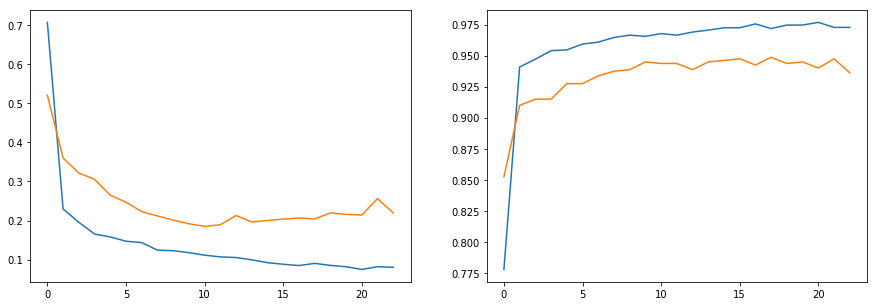

In [9]:
#結果をグラフ表示
import matplotlib.pyplot as plt
%matplotlib inline
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(result.epoch, result.history["loss"], label="Train loss")
ax_loss.plot(result.epoch, result.history["val_loss"], label="Validation loss")
ax_acc.plot(result.epoch, result.history["acc"], label="Train acc")
ax_acc.plot(result.epoch, result.history["val_acc"], label="Validation acc")

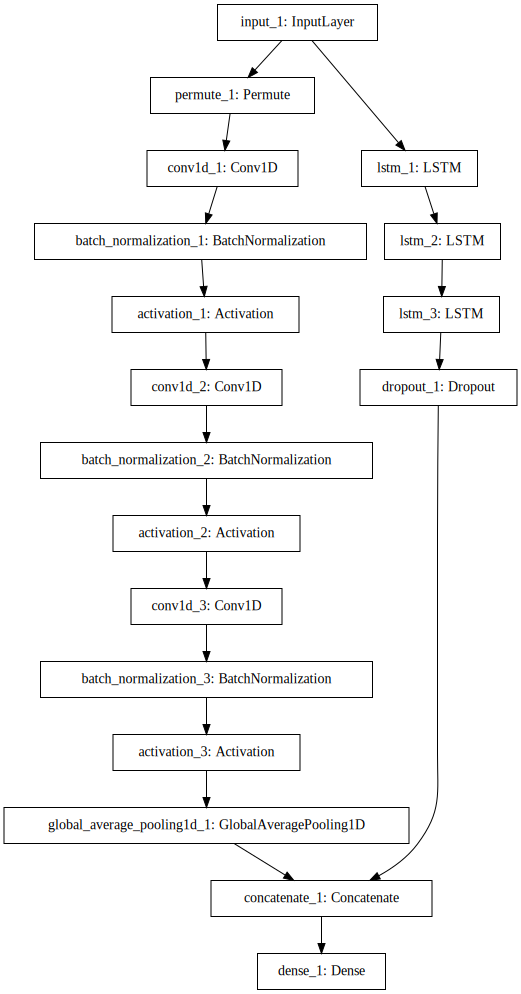

In [10]:
#モデル可視化
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))